# Document Similarity

This notebook introduces techniques for exploring document similarity. It's part of the [The Art of Literary Text Analysis](ArtOfLiteraryTextAnalysis.ipynb) (and assumes that you've already worked through previous notebooks – see the table of contents). In this notebook we'll look in particular at:

* [Document term matrix](#Document-Term-Matrix)
* [TF-IDF](#TF-IDF)
* [Cosine similarity](#Cosine-Similarity)
* [Visualizing document similarity with scatterplots](#Visualizing-Document-Distances-with-a-Scatterplot)
* [Visualizing document similarity with dendrograms](#Visualizing-Document-Clusters-with-a-Dendrogram)

A common task when working with a larger corpus is to try to determine how documents relate to one another – how similar or different they are, or how they might cluster together. For instance, if we take the 18 texts from the NTLK Gutenberg corpus, are there any texts that group together? There are several authors with multiple texts (Shakespeare, Austen, Chesterton), do these cluster together?

More importantly, how do we determine similarity? For instance, we could plot the ratio of sentences per number of words and see if that's helpful in determining stylistic similarity.

/usr/local/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/usr/local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/usr/local/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/usr/local/lib/python2.7/site-packages/scipy/interpolate/_bsplines.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  

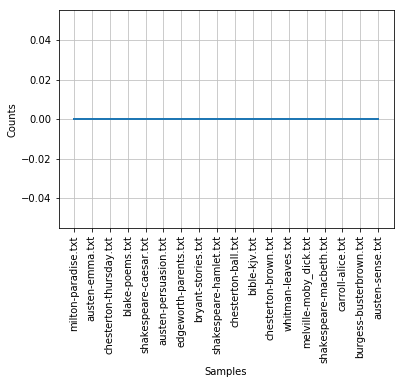

In [2]:
import nltk
%matplotlib inline

sentenceLengths = {}
for fileid in nltk.corpus.gutenberg.fileids():
    sentenceLengths[fileid] = len(nltk.corpus.gutenberg.sents(fileid)) / len(nltk.corpus.gutenberg.words(fileid))

nltk.FreqDist(sentenceLengths).plot()

We do indeed get a certain amount of grouping, for instance the first three texts are from Shakespeare, where there are a high number of sentences per total number of tokens. But this is perhaps more an indication of genre and even formatting rather than of vocabulary (indicated character names in the <a href="Glossary.ipynb#plaintexts" title="Text which includes only data related to the readable material." >plain text </a> plays are counted as sentences and the lines of text tend to be formatted shorter than in prose).

## Document Term Matrix

Another way to consider document similarity is to consider and compare the frequency of terms in each document. The first step in doing this is to create what's called a document term matrix where frequencies are indicated for each document – it might look something like this:

In [2]:
import pandas as pd

documents = [
    "I love jazz music and I love to read good books",
    "What good books have you read recently",
    "It's music to my ears when you say I love you"
]

allWords = set([word.lower() for word in nltk.word_tokenize(" ".join(documents)) if any([c for c in word if c.isalpha()])])
allRawFreqs = [nltk.FreqDist(nltk.word_tokenize(document.lower())) for document in documents]
pd.DataFrame(allRawFreqs).fillna(0)

,'s,and,books,ears,good,have,i,it,jazz,love,music,my,read,recently,say,to,what,when,you
0,0,1,1,0,1,0,2,0,1,2,1,0,1,0,0,1,0,0,0
1,0,0,1,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,1
2,1,0,0,1,0,0,1,1,0,1,1,1,0,0,1,1,0,1,2


The top row indicates each term in the entire corpus and each row represents a document ("0" is the first document "I love jazz…", etc.). This would be helpful (with real data), but it's not ideal to use raw frequencies (counts) since document length wouldn't be taken into consideration.

We could create a similar table using relative frequencies instead, in other words, where each value would be relative to the total number of tokens in the document. That would be better for <a href="Glossary.ipynb#Variable" title="A variable stores a piece of data and gives it a specific name" >variable </a> length documents, but an even more powerful (and commonly used) technique is to calculate a value that better represents the significance of a term within the corpus. Just as the relative frequency dampens counts based on document length, the [TF-IDF](http://en.wikipedia.org/wiki/Tf–idf) value dampens relative frequencies based on the distribution of the term in the corpus.

## TF-IDF

We already have the "TF" part of the TF-IDF value, it's simply the term's raw or relative frequency in a given document. We need to multiply that by IDF, which is the inverse document frequency, which we can calculate like this:

    IDF = log of the total number of documents divided by the number of documents that contain the term

So, imagine we want to calculate the TF-IDF score of the word "boot" for Austen's _Emma_ within the Gutenberg corpus:

* 4 occurrences of "boot" in _Emma_
* 16,1975 words in _Emma_
* 6 documents that contain "boot" (at least once)
* 18 documents in total

    TF = 4 / 161975 = 0.00002469516901

    IDF = log(18 /6) = 1.0986122886681098

    TF-IDF (for boot in _Emma_) = 0.00002469516901 \* 1.0986122886681098 = **0.00002713041615**

That seems like a lot of work for a single TF-IDF value for one term in one document. But good news! We don't need to calculate TF-IDF scores ourselves, there are several libraries that do that for us. In fact, we've already seen this with the gensim library in the topic modelling notebook, but here we're going to use [scikit](http://scikit-learn.org/stable/), a machine learning library for Python, and in particular with [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
simpledtm = TfidfVectorizer().fit_transform(documents) # takes a list of strings (and tokenizes them for us)
pd.DataFrame(simpledtm.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.372533,0.283321,0.000000,0.283321,0.000000,0.000000,0.372533,0.566642,0.283321,0.000000,0.283321,0.000000,0.000000,0.283321,0.000000,0.000000,0.000000
1,0.000000,0.329928,0.000000,0.329928,0.433816,0.000000,0.000000,0.000000,0.000000,0.000000,0.329928,0.433816,0.000000,0.000000,0.433816,0.000000,0.329928
2,0.000000,0.000000,0.332433,0.000000,0.000000,0.332433,0.000000,0.252824,0.252824,0.332433,0.000000,0.000000,0.332433,0.252824,0.000000,0.332433,0.505648


When we use this convenient method, we lose the term labels (they appear in the top header row as numbers from 0 to 16), but in fact that's not as important for now as just seeing that we have a document term matrix with TF-IDF values for each document and each term (with several values of zero).

We can generate a similar – though much larger – table for all the texts in the Gutenberg corpus.

In [4]:
names = nltk.corpus.gutenberg.fileids() # we'll keep track of filenames (for labels)
texts = [nltk.corpus.gutenberg.raw(fileid) for fileid in names] # a list of strings, one per document
documentTermMatrix = TfidfVectorizer().fit_transform(texts)
documentTermMatrix

<18x42063 sparse matrix of type '<class 'numpy.float64'>'
	with 121698 stored elements in Compressed Sparse Row format>

Our document term matrix is stored in something called a <a href="Glossary.ipynb#sparsematrix" title="An array of data arranged in a rectangular structure of columns and rows in which most of the elements are zero" >sparse matrix, </a> which is a useful and efficient way to store and process a very large table of data where several values are absent or not set. There are typically a lot of zero values in a <a href="Glossary.ipynb#sparsematrix" title="An array of data arranged in a rectangular structure of columns and rows in which most of the elements are zero" >sparse matrix, </a>  (imagine a term that only occurs in one of the 18 documents – a true matrix would need to store 18 cells/values, but a sparse matrix can store just one.

This document term matrix is conceptually enormous. Depending on the arguments we provide to fit_transform() we could have a huge table of 18 (the number of documents) by the total number of unique words in all the documents (each term is a column and each column needs a value for each one of the documents).

## Cosine Similarity

Even though we have a table of TF-IDF values for every term in every document, in order to make any use of it we need a way of comparing documents. In other words: of determining the distance between the frequency values (columns) for any of the documents in the rows. In effect, we want a way of expressing how different two rows (documents) are.

We can do this by converting our TF-IDF values from each document into geometric space. Imagine each term frequency (as TF-IDF) as a point on a <a href="Glossary.ipynb#cartesiangraph" title="Also known as the Cartesian Coordinate System" > cartesian graph</a> and a value that expresses the aggregate of these points. Each document could thus be expressed as a vector, or a line with a certain magnitude (length) and angle from the origin (0, 0).

Because the length of the line (the total magnitude of the total TF-IDF values) would be sensitive to the length of the document, we can't simply compare the lines for each document, but we can compare the angle between the documents – that's the essence of cosine similarity.

* cosine distance between document 1 and document 2 (d1, d2)
* cosine distance between document 2 and document 3 (d2, d3)
* cosine distance between document 1 and document 3 (d1, d3)


![Cosine Similarity](images/cosine-similarity.png)

We'll use scikit's [cosine_similarity](http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) function.

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
distances = 1 - cosine_similarity(documentTermMatrix)

This creates a new matrix not of individual terms but of distance measures between documents. Think of a table of distances between cities on a map, if you present it in a table there will be duplication, and identity values for where cities meet.

<table><tr><td></td><td>Calgary</td><td>Montreal</td><td>Toronto</td><td>Vancouver</td></tr><tr><td>Calgary</td><td></td><td>3750</td><td>3450</td><td>1050</td></tr><tr><td>Montreal</td><td>3750</td><td></td><td>550</td><td>4800</td></tr><tr><td>Toronto</td><td>3450</td><td>550</td><td></td><td>4500</td></tr><tr><td>Vancouver</td><td>1050</td><td>4800</td><td>4500</td><td></td></tr></table>

The distance values that we get from cosine_similarity() on our documentTermMatrix from Gutenberg are similar, we have an 18 by 18 grid. But the grid is still difficult to read, we want a way of visualizing distances.

## Visualizing Document Distances with a Scatterplot

An 18 by 18 grid can be thought of as an 18 dimensional dataset. Coordinates on a <a href="Glossary.ipynb#cartesiangraph" title="Also known as the Cartesian Coordinate System" > cartesian graph</a> are usually two dimensional, since we have x and y dimensions. So the question becomes: how do we convert a multidimensional grid into a two dimensional graph? Why, with [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) of course :). The math to accomplish this isn't as important for now as the purpose of multidimensional scaling to two dimensions, which is to represent as well as possible the distance that <a href="Glossary.ipynb#Object" title="Data which has attributes or values AND a defined behaviour." >objects </a> have in their original multiple dimensions.

In [6]:
from sklearn.manifold import MDS

# reduce our n-dimensional distances matrix to a two dimensional matrix (for x and y coordinates)
mds = MDS(dissimilarity="precomputed", random_state=1)
positions = mds.fit_transform(distances)

positions

array([[ -1.51868661e-01,  -4.31766715e-02],
       [ -9.58487860e-02,  -2.17179925e-02],
       [ -1.17381710e-01,  -7.46157660e-02],
       [  1.22382126e-01,   8.13713408e-02],
       [  1.40288239e-01,   4.29439050e-02],
       [  2.09094984e-02,   7.80592910e-02],
       [ -2.37332075e-01,   1.62232197e-01],
       [ -7.61926676e-03,   1.89215270e-01],
       [ -1.24747072e-02,   6.45721411e-02],
       [  1.96461441e-04,   4.67219521e-02],
       [ -3.43572845e-02,   9.69630518e-02],
       [ -4.09739841e-02,  -3.60270233e-03],
       [  3.78716690e-02,   3.76499973e-02],
       [  6.43095553e-02,  -5.06869192e-02],
       [ -4.25910013e-02,  -3.12768715e-01],
       [  8.34586205e-02,  -1.96712245e-01],
       [  1.82436839e-01,  -1.50882497e-01],
       [  8.85944675e-02,   5.44343623e-02]])

We now have a list of 18 elements (one for each Gutenberg text) where each text has an x and y value. Now all we need to do is plot the values.

In [1]:
import matplotlib.pyplot as plt

xvalues = positions[:, 0] # the left colunn (x axis) for all rows
yvalues = positions[: ,1] # the right column (y axis) for all rows

plt.figure(figsize=(10,10)) # make the graph easier to see
for x, y, name in zip(xvalues, yvalues, names):
    plt.scatter(x, y)
    plt.text(x, y, name.replace(".txt", ""))
plt.show()

NameError: name 'positions' is not defined

We can see a few encouraging clusters, including the authors Shakespeare (bottom right), Austen (middle left) and Chesterton (middle top).

## Visualizing Document Clusters with a Dendrogram

Another strategy for showing clusters is to create a hierarchical tree that forms a [dendrogram](http://en.wikipedia.org/wiki/Dendrogram). At its simplest, a dendrogram starts with each document in its own "cluster" and then tries to merge it with the closest document that still hasn't been merged. Those merged clusters are then merged again and the process is repeated as many times as possible. Different strategies exist for merging clusters based on distance matrix, but in this case we'll demonstrate [Ward](http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.ward.html#scipy.cluster.hierarchy.ward)'s approach.

/Users/sgs/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


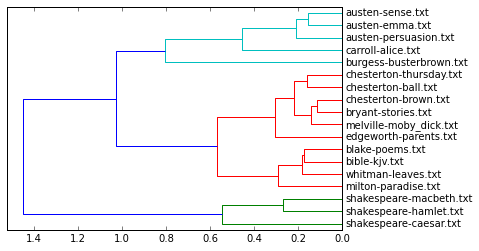

In [8]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(distances)
dendrogram(linkage_matrix, labels=names, orientation="right");
plt.show()  # fixes margins

The clustering of documents is arguably even easier to see here than in the scatterplot. We started the notebook by asking if we could find similarities and clusters of documents in the Gutenberg corpus, and the answer seems to be a resounding yes.

## See Also

* [Working with texts](https://de.dariah.eu/tatom/working_with_text.html) by Allen Riddell (to which this notebook is particularly indebted)

## Next Steps

Now let's get stuck into some utility examples with [Simple Sentiment Analysis](utilities/SimpleSentimentAnalysis.ipynb).

---
[CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/) From [The Art of Literary Text Analysis](ArtOfLiteraryTextAnalysis.ipynb) by [Stéfan Sinclair](http://stefansinclair.name) &amp; [Geoffrey Rockwell](http://geoffreyrockwell.com). Edited and revised by [Melissa Mony](http://melissamony.com). <br /> Created March 24, 2015 (run with Python 3.4)